![Seattle home, from https://traveler.marriott.com/seattle/](https://rvca738f6h5tbwmj3mxylox3-wpengine.netdna-ssl.com/wp-content/uploads/2019/08/GI_157380908_SeattleNeighborhoods.jpg)

# King County House Sales

## Introduction

This notebook provides recommendations to potential house flippers in King County, WA. Data on King County house sales is explored, and house sale prices are analyzed with linear regression models. Our final recommendations for flippers concern the potential value of making an addition to a home, whether houses with a basement are worth targeting for a flip, and how the condition of a house impacts sale price.

## Business Understanding

**Stakeholders:** Potential house flippers in King County, WA.

**Key Problems**

1. Which houses are worth buying to flip?
2. What actions can be taken after buying a house to increase its value for a flip?
    
**Assumptions**

- Sale price predictions based on interpretable features of homes are worthwhile to potential flippers.
- Information on the relative importance of features is useful to potential flippers to aid their decision-making.
- Home flippers are okay with a 95% significance level in their decision making, meaning there is a 5% chance a model or its coefficients are interpreted as statistically significantly different than 0 when they in fact are not.

These assumptions lend themselves to modeling house sale prices using linear regression models.

## Data Understanding

The data is stored in a csv file, `kc_house_data.csv`, and appears to be gathered from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction). The provenance of the data is unknown beyond this, including its original source, collection methods, and purpose.

The data contains house sale prices for King County, WA, which aligns with our stakeholders. Each record represents a house sale and contains price data along with 20 other columns. A data dictionary can be found [here](https://github.com/JenSans/Housing-Project/blob/main/data/column_names.md).

For our analysis, the target variable is price. This and other potentially useful columns will be inspected in this section.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

In [2]:
# import utils
from utils import evaluate, model_predict, interpret

In [3]:
# load the data
df = pd.read_csv('data/kc_house_data.csv')

# confirm load
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

There are 21,597 house sale entries and 21 columns. A handful are objects, which would need to be handled as categorical features. Some are coded as int64 or float64, but would need to be treated differently, such as `zipcode` or `yr_renovated`. Most columns do not contain null values, but `waterfront`, `view`, and `yr_renovated` do contain some nulls.

In order to properly assess our linear regression models, we will split the data into training and testing sets.

In [5]:
# create df of predictors, X, and our target, y
X = df.drop('price', axis=1)
y = df['price']

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 50)

# create combined train and test dataframes
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# confirm split
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16197 entries, 6465 to 14000
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16197 non-null  int64  
 1   date           16197 non-null  object 
 2   bedrooms       16197 non-null  int64  
 3   bathrooms      16197 non-null  float64
 4   sqft_living    16197 non-null  int64  
 5   sqft_lot       16197 non-null  int64  
 6   floors         16197 non-null  float64
 7   waterfront     14409 non-null  object 
 8   view           16150 non-null  object 
 9   condition      16197 non-null  object 
 10  grade          16197 non-null  object 
 11  sqft_above     16197 non-null  int64  
 12  sqft_basement  16197 non-null  object 
 13  yr_built       16197 non-null  int64  
 14  yr_renovated   13312 non-null  float64
 15  zipcode        16197 non-null  int64  
 16  lat            16197 non-null  float64
 17  long           16197 non-null  float64
 18  sqf

In [6]:
# take a look at summary statistics
train_df.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,1.619700e+04,16197.000000,16197.000000,16197.000000,1.619700e+04,16197.000000,16197.000000,16197.000000,13312.000000,16197.000000,16197.000000,16197.000000,16197.000000,16197.000000,1.619700e+04
mean,4.574580e+09,3.375502,2.117645,2082.103229,1.501166e+04,1.494166,1793.205779,1970.974625,84.279597,98077.818114,47.560210,-122.213990,1988.743348,12869.369883,5.414816e+05
std,2.869750e+09,0.921941,0.769608,920.166475,3.895139e+04,0.537562,830.940139,29.323161,401.456492,53.564139,0.138662,0.140042,688.273221,28070.766410,3.671641e+05
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,8.100000e+04
25%,2.125059e+09,3.000000,1.750000,1420.000000,5.040000e+03,1.000000,1200.000000,1951.000000,0.000000,98033.000000,47.470200,-122.327000,1490.000000,5100.000000,3.220000e+05
50%,3.904910e+09,3.000000,2.250000,1910.000000,7.632000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.572100,-122.231000,1840.000000,7634.000000,4.500000e+05
75%,7.305300e+09,4.000000,2.500000,2550.000000,1.064800e+04,2.000000,2220.000000,1997.000000,0.000000,98118.000000,47.678000,-122.124000,2370.000000,10050.000000,6.450000e+05
max,9.842301e+09,33.000000,8.000000,13540.000000,1.164794e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.316000,6210.000000,871200.000000,7.060000e+06


In [7]:
# take a look at the columns that are objects
obj_cols = [c for c in train_df.columns if train_df[c].dtype == 'object']
train_df[obj_cols].describe()

,date,waterfront,view,condition,grade,sqft_basement
count,16197,14409,16150,16197,16197,16197
unique,367,2,5,5,11,276
top,6/26/2014,NO,NONE,Average,7 Average,0.0
freq,105,14297,14585,10526,6728,9660


**Numeric Columns**
- At a cursory glance, many of the columns appear to be positively skewed, with means > medians and max values >> 75% values (e.g. `bedrooms`, `sqft_living`, `sqft_lot`, and our target of `price`). We'll take a closer look at some of these later.
- We see the examples of `zipcode` and `yr_renovated` yielding non-sensical descriptive statistics. `zipcode` is better treated as a categorical feature, and `yr_renovated` appears to have some hidden nulls coded as float 0.

**Object Columns**
- `date` has only 367 unique entries, alluding to about 1 year of data. We'll take a closer look at this later as it is a limitation of our model.
- There is imbalanced data concerning `waterfront` and `view`.
- `sqft_basement` is coded as an object, but seems better suited as a numeric column.

### Baseline Understanding

Before diving into more data exploration and preparation for modeling, let's try getting a baseline understanding of sale price. We'll use the mean price based on the training data as a naive prediction for sale price.

Training Metrics:
R2: 0.000
Mean Absolute Error: $234,875.98
Root Mean Squared Error: $367,152.72
----
Testing Metrics:
R2: -0.000
Mean Absolute Error: $232,751.86
Root Mean Squared Error: $367,987.21


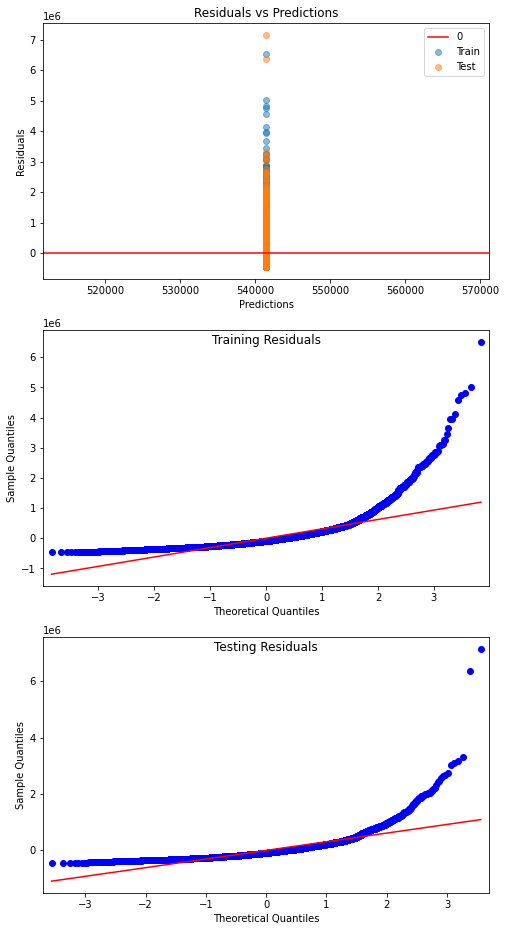

In [8]:
# mean price of the training data
mean_price = train_df['price'].mean()

# predictions for training data
y_train_preds = [mean_price] * len(train_df)

# prediction for testing data
y_test_preds = [mean_price] * len(test_df)

# evaluate the model-less predictions using our imported evaluate function
evaluate(train_df['price'], y_train_preds, test_df['price'], y_test_preds, log1p=False)

This model-less, baseline prediction captures 0% of the variance in sale price per the definition of R$^{2}$, has high bias, and has residuals which are positively skewed. The price prediction is off by more than $230,000 on average. Modeling sale price appears to be worthwhile since not much can be gleaned here.

## Data Preparation

In this section, we'll examine and clean all the features used in our final model. We'll also do some feature engineering.

### `sqft_living`

This is the square footage of living space in the home.

In [9]:
# inspect correlation of numeric columns with target, price
train_df.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.700481
sqft_above       0.602156
sqft_living15    0.586176
bathrooms        0.526186
lat              0.307136
bedrooms         0.302600
floors           0.257098
yr_renovated     0.134394
sqft_lot         0.092576
sqft_lot15       0.082877
yr_built         0.053602
long             0.022320
id              -0.017423
zipcode         -0.050696
Name: price, dtype: float64

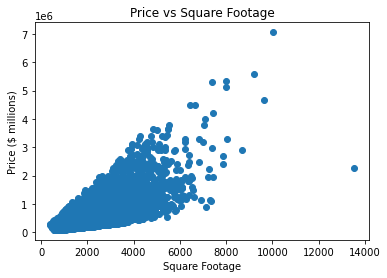

In [10]:
# scatter plot of price vs sqft_living
fig, ax = plt.subplots()
ax.scatter(train_df['sqft_living'], train_df['price'])
ax.set_xlabel('Square Footage')
ax.set_ylabel('Price ($ millions)')
ax.set_title('Price vs Square Footage');

`sqft_living` has the highest correlation with price at 0.70 in the train set. This feature will be used for modeling. Let's take a closer look at the distribution of `sqft_living`.

In [11]:
train_df['sqft_living'].describe()

count    16197.000000
mean      2082.103229
std        920.166475
min        370.000000
25%       1420.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

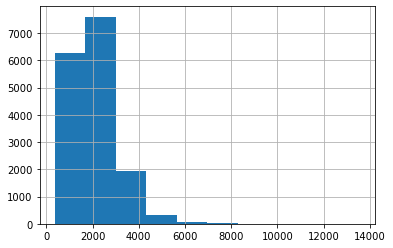

In [12]:
train_df['sqft_living'].hist();

In [13]:
# how many houses are over 4000 square feet
sum(train_df['sqft_living'] > 4000)

599

As seen earlier, `sqft_living` is highly right-skewed. There are also some very large houses in the training data. Given our stakeholders are potential home flippers, we will be excluding homes over 4000 square feet. Such houses are most likely larger investments that don't fit our stakeholders' needs.

In [14]:
# remove houses > 4000 square feet
train_df = train_df[train_df['sqft_living'] <= 4000]
test_df = test_df[test_df['sqft_living'] <= 4000]

# check training data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15598 entries, 6465 to 14000
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15598 non-null  int64  
 1   date           15598 non-null  object 
 2   bedrooms       15598 non-null  int64  
 3   bathrooms      15598 non-null  float64
 4   sqft_living    15598 non-null  int64  
 5   sqft_lot       15598 non-null  int64  
 6   floors         15598 non-null  float64
 7   waterfront     13871 non-null  object 
 8   view           15555 non-null  object 
 9   condition      15598 non-null  object 
 10  grade          15598 non-null  object 
 11  sqft_above     15598 non-null  int64  
 12  sqft_basement  15598 non-null  object 
 13  yr_built       15598 non-null  int64  
 14  yr_renovated   12810 non-null  float64
 15  zipcode        15598 non-null  int64  
 16  lat            15598 non-null  float64
 17  long           15598 non-null  float64
 18  sqf

### `price`

Price is suspected to be positively skewed based on the summary above and domain knowledge. Let's examine further and make a transformation to the target.

In [15]:
train_df['price'].describe()

count    1.559800e+04
mean     5.040045e+05
std      2.740086e+05
min      8.100000e+04
25%      3.175000e+05
50%      4.420000e+05
75%      6.190000e+05
max      3.100000e+06
Name: price, dtype: float64

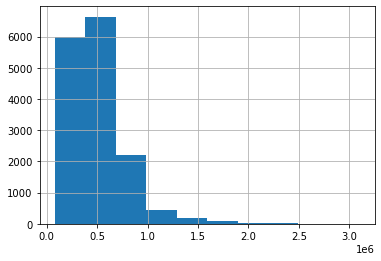

In [16]:
train_df['price'].hist();

Since price is positively skewed, we will transform it using the natural logarithm. This will make the target more normally distributed.

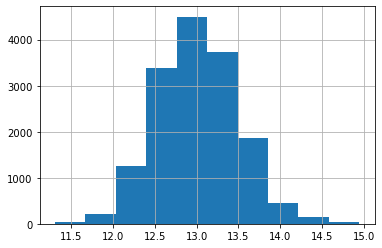

In [17]:
# transform price as ln(1+price)
train_df['log1p_price'] = train_df['price'].transform(np.log1p)
test_df['log1p_price'] = test_df['price'].transform(np.log1p)

# take a look at ln transformed price histogram
train_df['log1p_price'].hist();

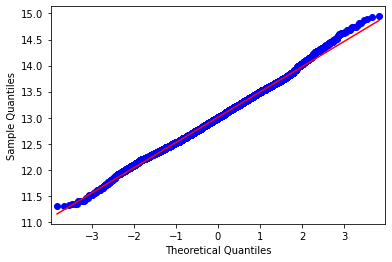

In [18]:
# QQ plot of ln transformed price
fig = sm.qqplot(train_df['log1p_price'], line='r')

As can be seen in the histogram of ln tranformed price and the QQ plot, this new target tracks closely with a normal distribution. This will be helpful when we build linear regression models. Let's take a quick look at this new target before moving on to the next feature.

In [19]:
train_df.corr()[['price', 'log1p_price']].sort_values('price', ascending=False)

,price,log1p_price
price,1.000000,0.932581
log1p_price,0.932581,1.000000
sqft_living,0.614252,0.634843
sqft_living15,0.558754,0.567826
sqft_above,0.501815,0.516698
bathrooms,0.444127,0.480817
lat,0.373823,0.475578
bedrooms,0.265484,0.292795
floors,0.245451,0.283261
yr_renovated,0.144679,0.121687


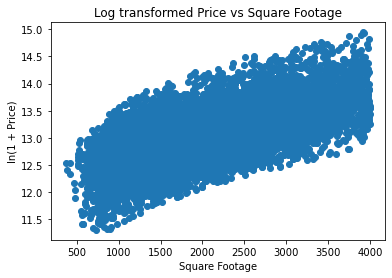

In [20]:
# scatter plot of ln transformed price vs sqft_living
fig, ax = plt.subplots()
ax.scatter(train_df['sqft_living'], train_df['log1p_price'])
ax.set_xlabel('Square Footage')
ax.set_ylabel('ln(1 + Price)')
ax.set_title('Log transformed Price vs Square Footage');

The relative order of strength of the correlations of the numeric features with this new target remains the same as before the transformation. `sqft_living` has a correlation of 0.63 with log transformed price.

### `sqft_living15`

This is the square footage of living space for the nearest 15 neighbors. The aggregation is suspected to be the mean, but is unknown.

In [21]:
train_df['sqft_living15'].describe()

count    15598.000000
mean      1932.981728
std        616.385479
min        399.000000
25%       1472.500000
50%       1810.000000
75%       2300.000000
max       5790.000000
Name: sqft_living15, dtype: float64

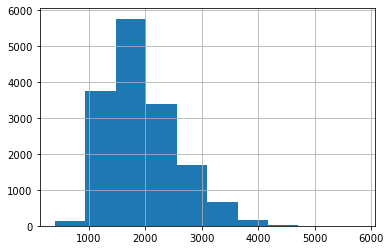

In [22]:
train_df['sqft_living15'].hist();

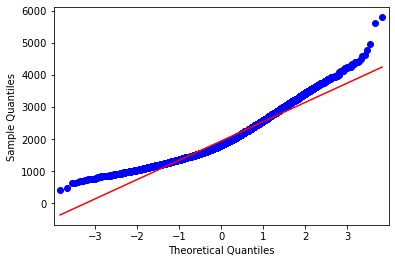

In [23]:
# QQ plot of sqft_living15
fig = sm.qqplot(train_df['sqft_living15'], line='r')

Similar to `sqft_living`, `sqft_living15` is right-skewed. We will create a **new feature** to compare the size of the home to its nearest 15 neighbors.

In [24]:
# create new feature, the ratio of the home's square footage to its nearest 15 neighbors
train_df['ratio_sqft_living'] = train_df['sqft_living'] / train_df['sqft_living15']
test_df['ratio_sqft_living'] = test_df['sqft_living'] / test_df['sqft_living15']

In [25]:
train_df['ratio_sqft_living'].describe()

count    15598.000000
mean         1.035917
std          0.299889
min          0.187279
25%          0.875000
50%          1.000000
75%          1.139765
max          6.000000
Name: ratio_sqft_living, dtype: float64

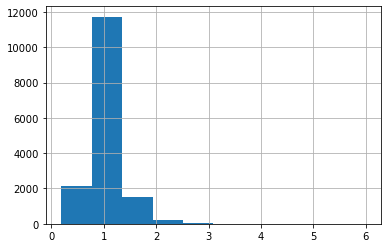

In [26]:
train_df['ratio_sqft_living'].hist();

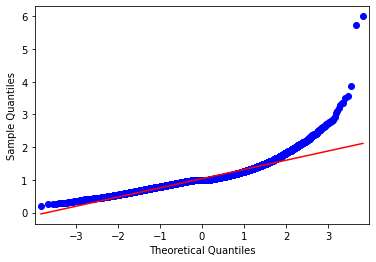

In [27]:
# QQ plot of ratio_sqft_living
fig = sm.qqplot(train_df['ratio_sqft_living'], line='r')

This new feature is right-skewed, but there appears to be some outliers affecting the distribution.

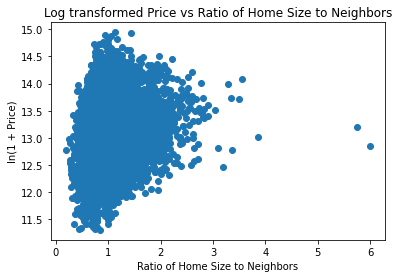

In [28]:
# scatter plot of ln transformed price vs ratio_sqft_living
fig, ax = plt.subplots()
ax.scatter(train_df['ratio_sqft_living'], train_df['log1p_price'])
ax.set_xlabel('Ratio of Home Size to Neighbors')
ax.set_ylabel('ln(1 + Price)')
ax.set_title('Log transformed Price vs Ratio of Home Size to Neighbors');

In [29]:
# how many houses are over 2x as large as their nearest 15 neighbors
sum(train_df['ratio_sqft_living'] > 2)

195

There are a handful of outliers above 3x as large as their neighbors. There are 195 homes in the training data that are over 2x as large. We will remove these homes from our analysis since it is unlikely they fit our home flippers' goals. We assume houses much larger than their neighbors are less likely to be flipped.

In [30]:
# remove houses > 2x as large as their nearest 15 neighbors
train_df = train_df[train_df['ratio_sqft_living'] <= 2]
test_df = test_df[test_df['ratio_sqft_living'] <= 2]

# check training data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15403 entries, 6465 to 14000
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15403 non-null  int64  
 1   date               15403 non-null  object 
 2   bedrooms           15403 non-null  int64  
 3   bathrooms          15403 non-null  float64
 4   sqft_living        15403 non-null  int64  
 5   sqft_lot           15403 non-null  int64  
 6   floors             15403 non-null  float64
 7   waterfront         13698 non-null  object 
 8   view               15360 non-null  object 
 9   condition          15403 non-null  object 
 10  grade              15403 non-null  object 
 11  sqft_above         15403 non-null  int64  
 12  sqft_basement      15403 non-null  object 
 13  yr_built           15403 non-null  int64  
 14  yr_renovated       12647 non-null  float64
 15  zipcode            15403 non-null  int64  
 16  lat                

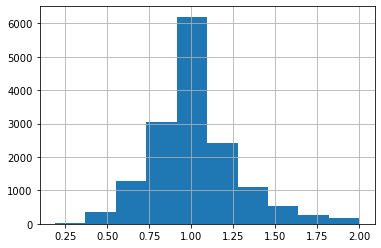

In [31]:
train_df['ratio_sqft_living'].hist();

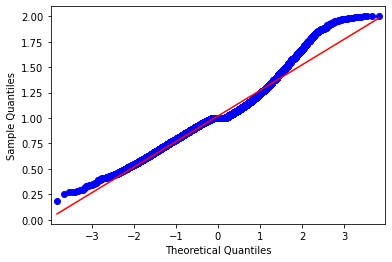

In [32]:
# QQ plot of ratio_sqft_living
fig = sm.qqplot(train_df['ratio_sqft_living'], line='r')

The ratio appears closer to a normal distribution after excluding homes larger than 2x their neighbors.

### `sqft_basement`

This is the square footage of the basement.

In [33]:
train_df['sqft_basement'].describe()

count     15403
unique      221
top         0.0
freq       9343
Name: sqft_basement, dtype: object

In [34]:
train_df['sqft_basement'].value_counts()

0.0       9343
?          331
500.0      154
700.0      154
600.0      149
          ... 
588.0        1
1798.0       1
862.0        1
556.0        1
1135.0       1
Name: sqft_basement, Length: 221, dtype: int64

This feature is an object, rather than a numeric. There are some hidden nulls coded as a "?". Let's examine those.

In [35]:
# check for difference in above and total square footage for those with '?' for sqft_basement
basement_miss = train_df[train_df['sqft_basement'] == '?'][['sqft_above', 'sqft_living']]
basement_miss

,sqft_above,sqft_living
6984,1020,1720
79,3450,3450
15477,2330,2330
14701,1840,1840
14483,1770,1770
...,...,...
21365,820,820
1356,1200,1200
881,1800,1800
17717,1520,1890


In [36]:
# the number of '?' which have a difference, which we assume means have a basement
sum(basement_miss['sqft_above'] != basement_miss['sqft_living'])

115

Out of 331 "?", there are 115 that appear to have a basement and 216 that don't. That brings the total to 9,343 + 216 = 9,559 houses out 15,403 houses in the training set without a basement according to `sqft_basement`. Let's see if this aligns with the following method of determing whether a house has a basement.

In [37]:
# find the difference in total and above square footage as an indicator of having a basement
train_df['sqft_diff'] = train_df['sqft_living'] - train_df['sqft_above']

# set new feature equal to 1 for basement, 0 for no basement
train_df['has_basement'] = np.where(train_df['sqft_diff'] > 0, 1, 0)

# check how many don't have a basement
sum(train_df['has_basement'] == 0)

9559

There are 9,559 houses without a basement according to this method as well! We'll update the test set similarly.

In [38]:
# update the test set with the new feature
test_df['sqft_diff'] = test_df['sqft_living'] - test_df['sqft_above']
test_df['has_basement'] = np.where(test_df['sqft_diff'] > 0, 1, 0)

### `condition`

This is the overall condition of the home as it relates to appearance, utility, and maintenance.

In [39]:
# Observe condition column
train_df['condition'].describe()

count       15403
unique          5
top       Average
freq         9922
Name: condition, dtype: object

In [40]:
# Check value counts
train_df['condition'].value_counts()

Average      9922
Good         4113
Very Good    1229
Fair          119
Poor           20
Name: condition, dtype: int64

In [41]:
# Observe the categories in condition
train_df['condition'].unique()

array(['Average', 'Very Good', 'Good', 'Fair', 'Poor'], dtype=object)

The `condition` feature is an object. We will apply an ordinal encoder to this feature for use in modeling. One limitation of this choice is that it assumes the intervals between conditions are equal.

In [42]:
# Create a list of these rankings in ascending order 
condition_rank = ['Poor', 'Fair', 'Average', 'Good', 'Very Good'] 

In [43]:
# Create a numeric column for this categorical feature using Ordinal Encoder
enc = OrdinalEncoder(categories=[condition_rank])
enc.fit(train_df[['condition']])

# Transform and create a dataframe to add to the training data
ranks = pd.DataFrame(enc.transform(train_df[['condition']]), columns=['condition_rank'], index=train_df.index)

# Update the training data
train_df['condition_rank'] = ranks

# Sanity check that condition_rank column is showing the same as the condition column
display(train_df['condition_rank'].value_counts())
display(train_df['condition'].value_counts())

2.0    9922
3.0    4113
4.0    1229
1.0     119
0.0      20
Name: condition_rank, dtype: int64

Average      9922
Good         4113
Very Good    1229
Fair          119
Poor           20
Name: condition, dtype: int64

This looks good. Let's apply the same to the test set.

In [44]:
# Transform and create a dataframe to add to the testing data
ranks = pd.DataFrame(enc.transform(test_df[['condition']]), columns=['condition_rank'], index=test_df.index)

# Update the testing data
test_df['condition_rank'] = ranks

# Sanity check that condition_rank column is showing the same as the condition column
display(test_df['condition_rank'].value_counts())
display(test_df['condition'].value_counts())

2.0    3309
3.0    1391
4.0     400
1.0      49
0.0       9
Name: condition_rank, dtype: int64

Average      3309
Good         1391
Very Good     400
Fair           49
Poor            9
Name: condition, dtype: int64

### `date` and `yr_built`

`date` is the date of the sale. `yr_built` is the year the house was built.

In [45]:
train_df['date'].describe()

count         15403
unique          365
top       6/26/2014
freq            103
Name: date, dtype: object

Let's convert the `date` column to a datetime object to make it easier to work with.

In [46]:
train_df['date'] = pd.to_datetime(train_df['date'])
print(train_df['date'].min(), train_df['date'].max())

2014-05-02 00:00:00 2015-05-24 00:00:00


It's confirmed that there is only about one year's worth of house sales for King County. This is a limitation of our modeling and recommendations.

In [47]:
train_df['yr_built'].describe()

count    15403.000000
mean      1970.312991
std         29.169369
min       1900.000000
25%       1951.000000
50%       1973.000000
75%       1995.000000
max       2015.000000
Name: yr_built, dtype: float64

We create a new feature to capture the age of a home when it was sold by finding the difference in these two columns. This will be rounded to the year.

In [48]:
# Create a new feature showing the age of the home when it was sold 
train_df['home_age_when_sold'] = train_df['date'].dt.year - train_df['yr_built']

test_df['date'] = pd.to_datetime(test_df['date'])
test_df['home_age_when_sold'] = test_df['date'].dt.year - test_df['yr_built']


# Sanity check
train_df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,long,sqft_living15,sqft_lot15,price,log1p_price,ratio_sqft_living,sqft_diff,has_basement,condition_rank,home_age_when_sold
6465,4139480190,2014-09-16,3,3.25,3780,10623,1.0,NO,FAIR,Average,...,-122.101,3850,11170,1150000.0,13.955273,0.981818,1130,1,2.0,15
17878,7454001210,2014-06-03,3,1.00,1040,6860,2.0,NO,NONE,Average,...,-122.375,1030,6512,239000.0,12.384223,1.009709,0,0,2.0,72
18830,686530530,2014-08-04,5,1.75,2510,9750,1.5,NO,NONE,Average,...,-122.149,1900,9750,570000.0,13.253393,1.321053,0,0,2.0,45
12147,5095401360,2014-11-21,3,2.50,2080,16050,1.0,NO,NONE,Very Good,...,-122.069,1790,14550,418000.0,12.943239,1.162011,720,1,4.0,36
14368,1352300120,2014-05-29,2,1.00,1500,4120,1.5,NO,NONE,Average,...,-122.200,1300,4120,262000.0,12.476104,1.153846,620,1,2.0,86


In [49]:
train_df['home_age_when_sold'].describe()

count    15403.000000
mean        44.014218
std         29.173137
min         -1.000000
25%         19.000000
50%         41.000000
75%         63.000000
max        115.000000
Name: home_age_when_sold, dtype: float64

There are some homes with -1 year ages when sold. Let's correct these assuming they should be 0.

In [50]:
# replace -1 home age with 0
corrected_home_age = train_df[train_df['home_age_when_sold'] < 0][['home_age_when_sold']].replace({-1:0})
train_df['home_age_when_sold'].loc[corrected_home_age.index] = corrected_home_age['home_age_when_sold']

corrected_home_age = test_df[test_df['home_age_when_sold'] < 0][['home_age_when_sold']].replace({-1:0})
test_df['home_age_when_sold'].loc[corrected_home_age.index] = corrected_home_age['home_age_when_sold']

# sanity check
train_df['home_age_when_sold'].describe()

C:\Users\whitm\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\whitm\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


count    15403.000000
mean        44.014737
std         29.172345
min          0.000000
25%         19.000000
50%         41.000000
75%         63.000000
max        115.000000
Name: home_age_when_sold, dtype: float64

## Modeling and Evaluation

This section covers the linear regression modeling and evaluation. Models were iteratively built and evaluated according to their business relevance and their alignment with the assumptions of linear regression.

Business relevance:
- R$^{2}$: a measure of how much of the variation in sale price is predicted by our model. This is a decimal up to 1. This metric is worthwhile for home flippers looking for a useful prediction of price when considering buying or selling a home.
- MAE and RMSE: measures of the "average" errors in price prediction. RMSE is inflated by large errors more so than MAE. Both metrics are in units of \\$. These are relevant metrics for considering the usefulness of model price predictions.

Linear regression assumptions:
- Linearity: assumes a linear relationship between features and target, `log1p_price`.
    - Evaluated with scatter plots and correlation matrix.
- Multicollinearity: assumes the features themselves do not have a linear relationship with one another.
    - Evaluated with scatter plots and correlation matrix.
- Normality: assumes the residuals (target observations - target predictions) are normally distributed with mean 0.
    - Evaluated with QQ plots.
- Homoscedasticity: assumes the residuals have equal variance along the predictions.
    - Evaluated with scatter plots.

In [51]:
# features used in model iteration
features = ['sqft_living', 'ratio_sqft_living', 'has_basement', 'condition_rank', 'home_age_when_sold']

# select the train and test sets to include only these features and the two potential targets, price and log1p_price
train_df = train_df[features + ['price', 'log1p_price']]
test_df = test_df[features + ['price', 'log1p_price']]

# check
train_df

,sqft_living,ratio_sqft_living,has_basement,condition_rank,home_age_when_sold,price,log1p_price
6465,3780,0.981818,1,2.0,15,1150000.0,13.955273
17878,1040,1.009709,0,2.0,72,239000.0,12.384223
18830,2510,1.321053,0,2.0,45,570000.0,13.253393
12147,2080,1.162011,1,4.0,36,418000.0,12.943239
14368,1500,1.153846,1,2.0,86,262000.0,12.476104
...,...,...,...,...,...,...,...
14565,1800,1.090909,1,4.0,68,719000.0,13.485618
15649,1010,0.795276,0,2.0,61,185000.0,12.128117
10123,2130,1.126984,0,2.0,24,546500.0,13.211291
5600,1690,0.913514,0,2.0,18,265000.0,12.487489


In [52]:
# check
test_df

,sqft_living,ratio_sqft_living,has_basement,condition_rank,home_age_when_sold,price,log1p_price
3879,1670,1.098684,1,2.0,0,589950.0,13.287795
12341,1060,0.679487,0,3.0,31,275000.0,12.524530
5329,2160,1.878261,1,4.0,89,625000.0,13.345509
19235,1360,0.844720,0,2.0,28,260000.0,12.468441
14722,1560,1.560000,0,2.0,47,295000.0,12.594734
...,...,...,...,...,...,...,...
11653,1790,0.836449,1,2.0,29,410000.0,12.923915
8219,1920,1.000000,0,2.0,16,380600.0,12.849507
20912,2660,1.112971,0,2.0,4,287000.0,12.567241
12623,1410,0.477966,0,3.0,30,335000.0,12.721889


### Baseline Understanding Revisited

Let's look at the model-less, baseline prediction for sale price again, this time after preparing our data for modeling.

Training Metrics:
R2: 0.000
Mean Absolute Error: $195,337.28
Root Mean Squared Error: $272,648.77
----
Testing Metrics:
R2: -0.000
Mean Absolute Error: $193,516.18
Root Mean Squared Error: $265,657.29


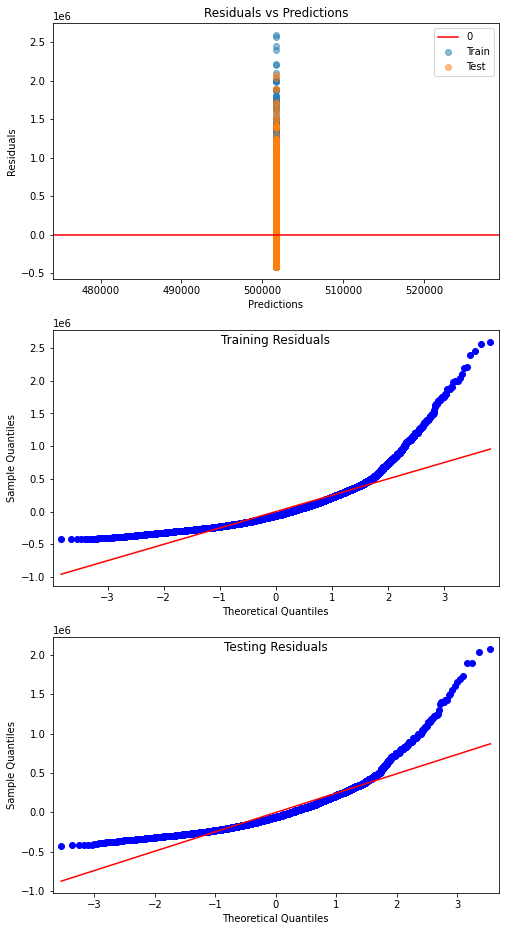

In [53]:
# mean price of the training data
mean_price = train_df['price'].mean()

# predictions for training data
y_train_preds = [mean_price] * len(train_df)

# prediction for testing data
y_test_preds = [mean_price] * len(test_df)

# evaluate the model-less predictions using our imported evaluate function
evaluate(train_df['price'], y_train_preds, test_df['price'], y_test_preds, log1p=False)

After preparing the data for modeling, the test MAE has decreased from \\$233,000 to \\$194,000. The test RMSE has decreased from \\$368,000 to \\$266,000.

### First Substandard Model

The first model created after the model-less, baseline prediction is a simple linear regression model of `price` by `sqft_living`. The correlation is highest between this feature and the target compared to all other features.

In [54]:
train_df.corr()['price'].sort_values(ascending=False)[features]

sqft_living           0.613306
ratio_sqft_living     0.208634
has_basement          0.178330
condition_rank        0.063574
home_age_when_sold   -0.005239
Name: price, dtype: float64

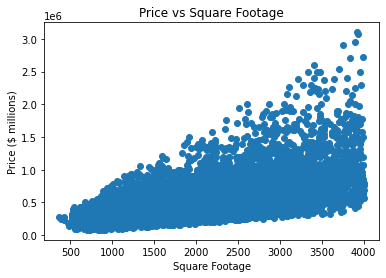

In [55]:
# scatter plot of price vs sqft_living
fig, ax = plt.subplots()
ax.scatter(train_df['sqft_living'], train_df['price'])
ax.set_xlabel('Square Footage')
ax.set_ylabel('Price ($ millions)')
ax.set_title('Price vs Square Footage');

Linearity: The relationship is roughly linear, but definitely noisy. Good enough for a first model.

Multicollinearity: N/A since only one feature.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     9286.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:37:32   Log-Likelihood:            -2.1101e+05
No. Observations:               15403   AIC:                         4.220e+05
Df Residuals:                   15401   BIC:                         4.220e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.503e+04   4949.042     11.120      0.000    4.53e+04    6.47e+04
sqft_living   227.3680      2.359     96.363      0.000     222.743     231.993
==============================================================================
Omnibus:                     7034.697   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            67574.610
Skew:                           1.956   Prob(JB):                         0.00
Kurtosis:                      12.486   Cond. No.                     5.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Training Metrics:
R2: 0.376
Mean Absolute Error: $152,633.78
Root Mean Squared Error: $215,350.42
----
Testing Metrics:
R2: 0.368
Mean Absolute Error: $151,424.75
Root Mean Squared Error: $211,098.52


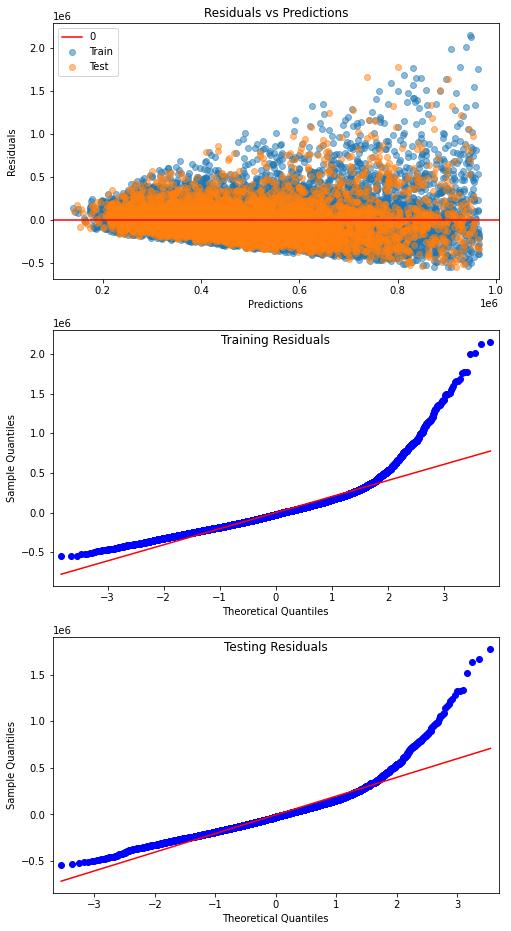

In [56]:
# predictions for train and test set, model_predict is a utils function using statsmodels.OLS
y_train_preds, y_test_preds = model_predict(train_df,
                                            ['sqft_living'],
                                            'price',
                                            test_df)

# evaluate the model, evaluate is a utils function displaying metrics and plots for evaluation
evaluate(train_df['price'], y_train_preds, test_df['price'], y_test_preds, log1p=False)

Compared to the baseline, the test MAE has decreased from \\$194,000 to \\$151,000. The test RMSE has decreased from \\$266,000 to \\$211,000. This simple linear regression model has a 0.368 test R$^{2}$.

Normality: Residuals are right-skewed.

Homoscedasticity: Residuals are heteroscedastic. There is higher variance in the residuals at higher price predictions.

Because of these poor results in normality and homoscedasticity, the next model created looked at the transformed price vs square footage.

### Modeling Iterations

### `log1p_price` by `sqft_living`

In [57]:
train_df.corr()['log1p_price'].sort_values(ascending=False)[features]

sqft_living           0.633284
ratio_sqft_living     0.237883
has_basement          0.204725
condition_rank        0.055247
home_age_when_sold   -0.041126
Name: log1p_price, dtype: float64

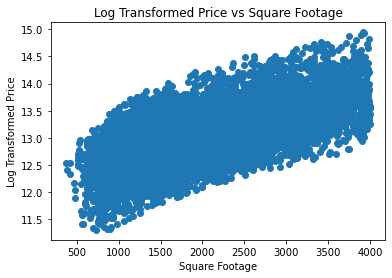

In [58]:
# scatter plot of log1p_price vs sqft_living
fig, ax = plt.subplots()
ax.scatter(train_df['sqft_living'], train_df['log1p_price'])
ax.set_xlabel('Square Footage')
ax.set_ylabel('Log Transformed Price')
ax.set_title('Log Transformed Price vs Square Footage');

Linearity: The relationship is linear, but definitely noisy.

Multicollinearity: N/A since only one feature.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log1p_price   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                 1.031e+04
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:37:33   Log-Likelihood:                -6721.4
No. Observations:               15403   AIC:                         1.345e+04
Df Residuals:                   15401   BIC:                         1.346e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.1870      0.009   1416.591      0.000      12.170      12.204
sqft_living     0.0004    4.1e-06    101.549      0.000       0.000       0.000
==============================================================================
Omnibus:                       53.469   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.527
Skew:                           0.056   Prob(JB):                     3.53e-10
Kurtosis:                       2.765   Cond. No.                     5.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Training Metrics:
R2: 0.401
Mean Absolute Error: $148,920.49
Root Mean Squared Error: $215,564.00
----
Testing Metrics:
R2: 0.395
Mean Absolute Error: $147,826.20
Root Mean Squared Error: $211,775.38


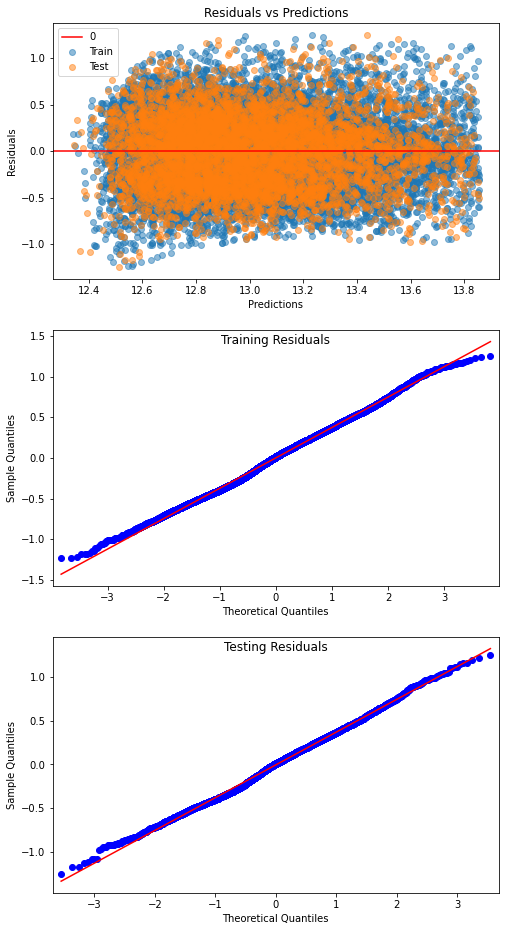

In [59]:
# predictions for train and test set
y_train_preds, y_test_preds = model_predict(train_df,
                                            ['sqft_living'],
                                            'log1p_price',
                                            test_df)

# evaluate the model
evaluate(train_df['log1p_price'], y_train_preds, test_df['log1p_price'], y_test_preds)

Log transforming the target results in a decrease in the test MAE by about \\$3,600. The test RMSE is roughly the same as before. The test R$^{2}$ has increased from 0.368 to 0.395.

Normality: Residuals are not visually skewed, but have slightly thin tails. Closer to normal than raw price by square footage.

Homoscedasticity: Residuals are less heteroscedastic than those of the first model.

### `sqft_living` and `ratio_sqft_living`

We tried different iterations of our five features and `log1p_price`. The more features we used, the better each of the metrics became while the assumptions of linear modeling weren't much worse off. We'll take a look at one such iteration before moving on to our final model.

In [60]:
train_df[['sqft_living', 'ratio_sqft_living', 'log1p_price']].corr()

,sqft_living,ratio_sqft_living,log1p_price
sqft_living,1.000000,0.546198,0.633284
ratio_sqft_living,0.546198,1.000000,0.237883
log1p_price,0.633284,0.237883,1.000000


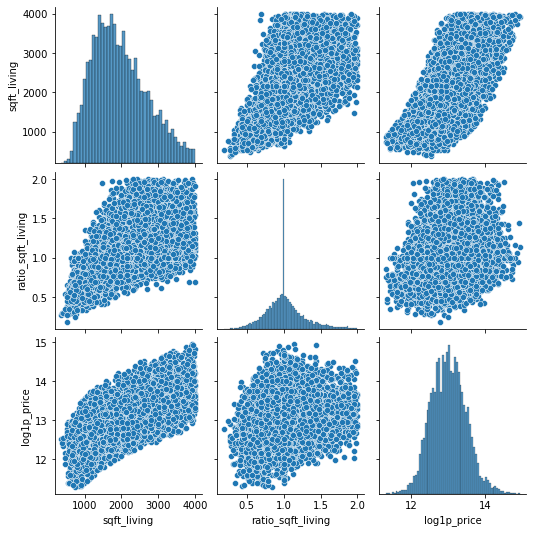

In [61]:
sns.pairplot(train_df[['sqft_living', 'ratio_sqft_living', 'log1p_price']]);

Linearity: The relationship between `log1p_price` and `ratio_sqft_living` is not clearly linear.

Multicollinearity: The relationship between `sqft_living` and `ratio_sqft_living` has a 0.55 correlation. It doesn't look too strongly linear, but worthwhile to call out.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log1p_price   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     5523.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:37:36   Log-Likelihood:                -6504.6
No. Observations:               15403   AIC:                         1.302e+04
Df Residuals:                   15400   BIC:                         1.304e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                12.3739      0.012   1005.536      0.000      12.350      12.398
sqft_living           0.0005   4.83e-06     97.720      0.000       0.000       0.000
ratio_sqft_living    -0.2900      0.014    -20.970      0.000      -0.317      -0.263
==============================================================================
Omnibus:                       88.523   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.001
Skew:                           0.036   Prob(JB):                     1.27e-14
Kurtosis:                       2.692   Cond. No.                     1.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Training Metrics:
R2: 0.418
Mean Absolute Error: $147,494.17
Root Mean Squared Error: $212,230.44
----
Testing Metrics:
R2: 0.413
Mean Absolute Error: $146,484.19
Root Mean Squared Error: $208,691.35


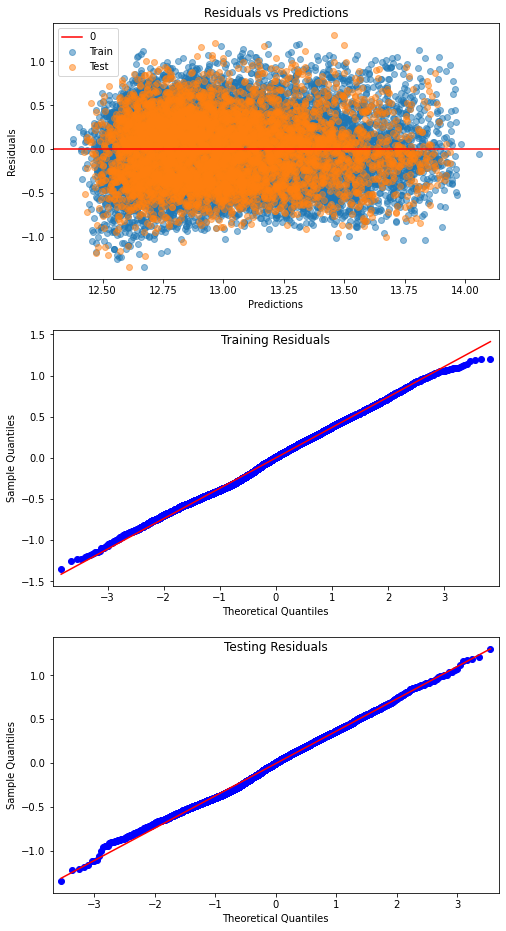

In [62]:
# predictions for train and test set
y_train_preds, y_test_preds = model_predict(train_df,
                                            ['sqft_living', 'ratio_sqft_living'],
                                            'log1p_price',
                                            test_df)

# evaluate the model
evaluate(train_df['log1p_price'], y_train_preds, test_df['log1p_price'], y_test_preds)

The test MAE and RMSE have decreased by about \\$1,000 and \\$3,000, respectively. The test R$^{2}$ has increased from 0.395 to 0.413.

Normality: Residuals track pretty close to normal.

Homoscedasticity: Residuals look similar to the previous iteration, mostly homoscedastic. There does seem to be higher variance at lower price predictions.

### Final Model

Our final model incorporates all 5 of our features into a multiple linear regression model.

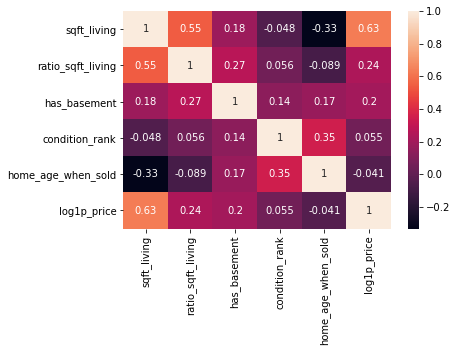

In [63]:
sns.heatmap(train_df[features + ['log1p_price']].corr(), annot=True); 

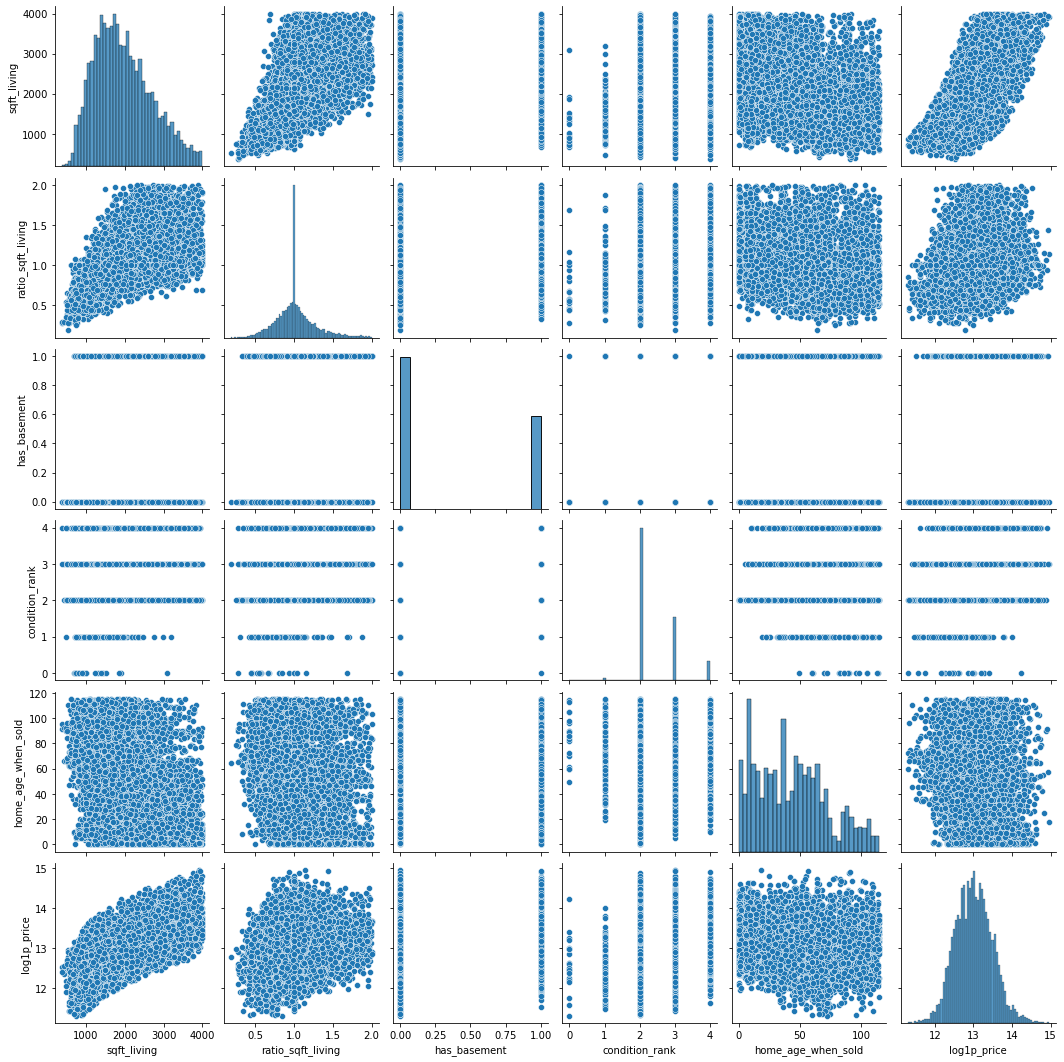

In [64]:
sns.pairplot(train_df[features + ['log1p_price']]);

Linearity: The relationships between `log1p_price` and `ratio_sqft_living` or `home_age_when_sold` is not clearly linear. 

Multicollinearity: The relationships between the five features do not appear to have multicollinearity issues.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log1p_price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     2653.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:37:44   Log-Likelihood:                -5882.7
No. Observations:               15403   AIC:                         1.178e+04
Df Residuals:                   15397   BIC:                         1.182e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.1536      0.016    753.061      0.000      12.122      12.185
sqft_living            0.0005   4.98e-06    104.426      0.000       0.001       0.001
ratio_sqft_living     -0.3773      0.014    -27.693      0.000      -0.404      -0.351
has_basement           0.0770      0.006     12.200      0.000       0.065       0.089
condition_rank         0.0223      0.005      4.741      0.000       0.013       0.032
home_age_when_sold     0.0030      0.000     26.269      0.000       0.003       0.003
==============================================================================
Omnibus:                       13.887   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.495
Skew:                          -0.056   Prob(JB):                      0.00117
Kurtosis:                       2.908   Cond. No.                     1.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Training Metrics:
R2: 0.463
Mean Absolute Error: $138,864.70
Root Mean Squared Error: $199,044.46
----
Testing Metrics:
R2: 0.450
Mean Absolute Error: $138,978.64
Root Mean Squared Error: $197,395.59


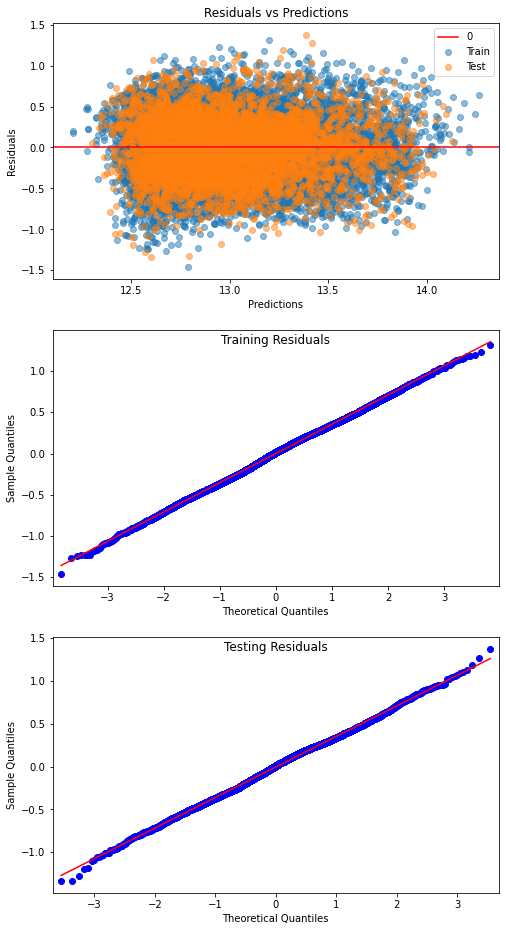

In [65]:
# predictions for train and test set
y_train_preds, y_test_preds = model_predict(train_df,
                                            features,
                                            'log1p_price',
                                            test_df)

# evaluate the model
evaluate(train_df['log1p_price'], y_train_preds, test_df['log1p_price'], y_test_preds)

The test MAE and RMSE are about \\$139,000 and \\$197,000, respectively. The test R$^{2}$ is 0.45.

Normality: Residuals track pretty close to normal.

Homoscedasticity: Residuals look mostly homoscedastic. There does seem to be higher variance at lower price predictions.

**Final Model Interpretation**

The model does not appear to be overfit on the training data since the metrics and residuals are very similar on the testing data. Compared to the baseline model test R$^{2}$ of 0.368, this model is better. The baseline test MAE of \\$151,000 and test RMSE of \\$211,000 are also worse off than this final model.

Overall, this model is statistically significant since the p-value for the F-stat is 0.00, lower than our 0.05 alpha level assumed for potential home flippers. In addition, each coefficient is statistically significant since all the p-values are 0.000, lower than our 0.05 alpha.

We are not too confident this model would benefit potential house flippers given its MAE of about \\$139,000 for price predictions. Not putting extra weight on large errors in price prediction, this MAE value is much too high to take price predictions from our model with any confidence.

There are limitations to this model which will be discussed in the concluding section. Before that, let's take a look at interpreting some coefficients and rank their relative importance in the model.

#### Coefficients

Since the target of `price` was log transformed, we will interpret the coefficients using the following method.

$\beta$ = coefficient of interest for a feature

$x$ = a feature

$y$ = the raw target, price for our model

$z$ = variable unit of change

A ***one unit*** increase in $x$ yields roughly...

an $[(e^{\beta} - 1) * 100]$% change in y.

A ***z unit*** increase in $x$ yields roughly...

an $[(e^{\beta z} - 1) * 100]$% change in y.

We'll use sklearn's LinearRegression to programmatically retrieve the regression coefficients.

In [66]:
# Instantiate our model
final_model = LinearRegression()

# Fit our model
final_model.fit(train_df[features], train_df['log1p_price'])

# Grab our coefficients with feature names
final_model_coef = dict(zip(features, final_model.coef_))
final_model_coef

{'sqft_living': 0.0005197590309992201,
 'ratio_sqft_living': -0.37731694321879705,
 'has_basement': 0.0769941963657104,
 'condition_rank': 0.02232912282968099,
 'home_age_when_sold': 0.002999469613779653}

In [67]:
for feature in final_model_coef.keys():
    change = interpret(final_model_coef, feature, 1)
    print(f"A one unit increase in {feature} yields a {change:.2f}% change in price.")

A one unit increase in sqft_living yields a 0.05% change in price.
A one unit increase in ratio_sqft_living yields a -31.43% change in price.
A one unit increase in has_basement yields a 8.00% change in price.
A one unit increase in condition_rank yields a 2.26% change in price.
A one unit increase in home_age_when_sold yields a 0.30% change in price.


A one unit increase in `sqft_living` means literally *one* additional square foot. Let's up that to 100 square feet, or a 10x10 ft room.

In [68]:
interpret(final_model_coef, 'sqft_living', 100)

5.335035972917734

Therefore, according to our model, holding all other features constant, an additional 10x10 ft room results in a 5.34% increase in the price.

A one unit increase in `ratio_sqft_living` means going from 0.5 to 1.5 for example, or half the size of your neighbors to 1.5 times the size of your neighbors. According to our model, this change results in a 31.43% decrease in price, holding all other features constant. So, homes appear to be priced higher when they are smaller rather than larger than their neighbors, all else equal.

Having a basement vs not having one results in an 8% increase in sale price.

A one unit change in `condition_rank` means going up one level from one rating to the next (e.g. poor to fair, or average to good). A limitation of our model is the assumption that these intervals are equivalent when they may not be. According to our model, jumping up one rating results in a 2.26% increase in price, holding other features constant.

In [69]:
interpret(final_model_coef, 'condition_rank', 2)

4.567043642615687

For going up two conditions, from average (the mode) to very good, a 4.57% increase in price is predicted by our model.

Finally, one of the limitations of our model is that these features don't capture much of the variation in sale price, to the degree that there are almost certainly confounding features unaccounted for. One implication of this is that, according to our model, older homes are predicted to have a higher price, holding all other features constant. This could be picking up the fact that certain wealthy neighbors may have relatively older homes. If location were accounted for, this trend may hold or even reverse.

#### Relative Importance of Coefficients

To wrap up this model evaluation, let's put the features on the same scale to compare their relative importance to the model's prediction of price. We'll use the MinMaxScaler on all the features since we have a boolean feature, `has_basement`.

In [70]:
#instantiate scaler
mmscaler = MinMaxScaler()

# learn from the training data
mmscaler.fit(train_df[features])

# Apply to training and testing data
mmtrain_df = pd.DataFrame(mmscaler.transform(train_df[features]), columns=features, index=train_df.index)
mmtest_df = pd.DataFrame(mmscaler.transform(test_df[features]), columns=features, index=test_df.index)

# Add in target
mmtrain_df['log1p_price'] = train_df['log1p_price']
mmtest_df['log1p_price'] = test_df['log1p_price']

# check
mmtrain_df

,sqft_living,ratio_sqft_living,has_basement,condition_rank,home_age_when_sold,log1p_price
6465,0.939394,0.438313,1.0,0.50,0.130435,13.955273
17878,0.184573,0.453699,0.0,0.50,0.626087,12.384223
18830,0.589532,0.625454,0.0,0.50,0.391304,13.253393
12147,0.471074,0.537718,1.0,1.00,0.313043,12.943239
14368,0.311295,0.533213,1.0,0.50,0.747826,12.476104
...,...,...,...,...,...,...
14565,0.393939,0.498494,1.0,1.00,0.591304,13.485618
15649,0.176309,0.335405,0.0,0.50,0.530435,12.128117
10123,0.484848,0.518395,0.0,0.50,0.208696,13.211291
5600,0.363636,0.400632,0.0,0.50,0.156522,12.487489


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log1p_price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     2653.
Date:                Fri, 08 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:37:45   Log-Likelihood:                -5882.7
No. Observations:               15403   AIC:                         1.178e+04
Df Residuals:                   15397   BIC:                         1.182e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 12.2752      0.015    842.193      0.000      12.247      12.304
sqft_living            1.8867      0.018    104.426      0.000       1.851       1.922
ratio_sqft_living     -0.6840      0.025    -27.693      0.000      -0.732      -0.636
has_basement           0.0770      0.006     12.200      0.000       0.065       0.089
condition_rank         0.0893      0.019      4.741      0.000       0.052       0.126
home_age_when_sold     0.3449      0.013     26.269      0.000       0.319       0.371
==============================================================================
Omnibus:                       13.887   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.495
Skew:                          -0.056   Prob(JB):                      0.00117
Kurtosis:                       2.908   Cond. No.                         14.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Training Metrics:
R2: 0.463
Mean Absolute Error: $138,864.70
Root Mean Squared Error: $199,044.46
----
Testing Metrics:
R2: 0.450
Mean Absolute Error: $138,978.64
Root Mean Squared Error: $197,395.59


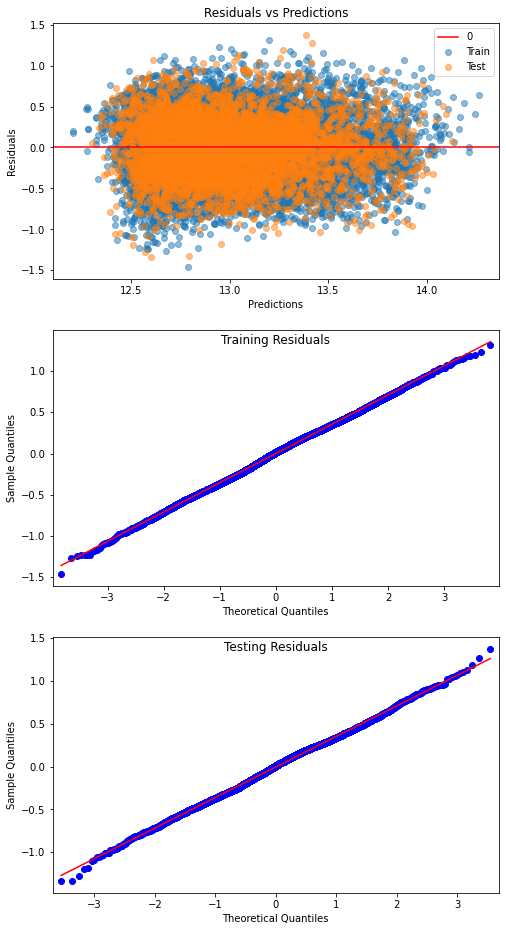

In [71]:
# predictions for train and test set
y_train_preds, y_test_preds = model_predict(mmtrain_df,
                                            features,
                                            'log1p_price',
                                            mmtest_df)

# evaluate the model
evaluate(mmtrain_df['log1p_price'], y_train_preds, mmtest_df['log1p_price'], y_test_preds)

This looks good since the only difference between the unscaled and scaled final model is the coefficients. Let's use sklearn LinearRegression to easily grab the coefficients again.

In [72]:
# Instantiate our model
mmfinal_model = LinearRegression()

# Fit our model
mmfinal_model.fit(mmtrain_df[features], mmtrain_df['log1p_price'])

# Grab our coefficients with feature names
mmfinal_model_coef = pd.DataFrame.from_dict(dict(zip(features, mmfinal_model.coef_)),
                                            orient='index',
                                            columns=['coefficients'])
# sort them after taking absolute value
mmfinal_model_coef['coefficients'].abs().sort_values(ascending=False)

sqft_living           1.886725
ratio_sqft_living     0.683970
home_age_when_sold    0.344939
condition_rank        0.089316
has_basement          0.076994
Name: coefficients, dtype: float64

The relative importance of our five feature is above. `sqft_living` is more than twice as important as `ratio_sqft_living`, which itself is twice as important as `home_age_when_sold`.

## Conclusions

**Recommendations**
- If you already have a home you'd like to flip:
    - compare the cost of a 100-square-foot addition to the home to a 5% increase in home price to see if this is profitable for a flip.
- If you are comparing similar homes and their potential for flipping:
    - if one has a basement and the other doesn't, consider purchasing and flipping the home that has the basement if the difference in price is less than 8%.
    - consider purchasing a home in poor or fair condition and upgrading them to good or very good, respectively.

**Limitations**
- The data we have is limited in scope as it is from May 2014 to May 2015. The model and our analysis may not generalize beyond this time period.
- The model assumes equal intervals between each home condition. This may not be true in reality and be masking some predictive power or lack thereof.
- The model lacks any location data. Domain knowledge suggests this data would be quite meaningful to the model's predictions. Coefficients may be confounded by location features and increase, decrease, or even reverse in size with location features added to the linear regression model.
- With an MAE of \\$139,000 the recommendations from this model should be taken with a large grain of salt, though the model is statistically significant.

**Next Steps**
- Explore location data in the King County House Sales csv.
- Bring in outside location-related data on neighboring average income, school ratings, safety scores, etc.
- Explore additional size-related features, like floors, bedrooms, bathrooms.